# BioEn Enemble Refinement with data from Circular dichroism (CD) measurements
(This Jupyter notebook documents the use of BioEn with an ensemble of conformations of p53, which were generated with Rosetta.)

By applying this ipython notebook, we can perform ensemble refinement with CD data using BioEn. The steps of the Jupyter notebook are <br> 

1. Preparation of the input <br> 
2. BioEn <br> 
3. Analysis of the BioEn results<br> 

You can either use the provided test data or define your input data set.


### Theory and methods applied in this Jupyter notebook are available in:

G. Hummer, J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

### Experimental CD data used in this Jupyter notebook are published in:
Yadahalli, Shilpa, José L. Neira, Christopher M. Johnson, Yaw Sing Tan, Pamela JE Rowling, Anasuya Chattopadhyay, Chandra S. Verma, and Laura S. Itzhaki, "Kinetic and thermodynamic effects of phosphorylation on p53 binding to MDM2" Scientific reports, 9(1), 693 (2019).

In [1]:
import numpy as np
import pickle
import pandas as pd

#import MDAnalysis as mda
#import MDAnalysis.analysis.align
#import MDAnalysis.lib.NeighborSearch as KDNS
#import MDAnalysis.analysis.distances

#from scipy.special import fresnel

import matplotlib as m
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

%matplotlib inline

## Define paths to the experimental and simulated data and for the output of preparation, BioEn, and analysis of the BioEn runs

In [2]:
%%capture
! mkdir files/output_bioen
! mkdir files/output_analysis

# path to experimental data
path_experimental_data = "files/experimental_data/"

# path to simulated data
path_simulated_data = "files/simulated_data/"

# number of ensemble members/conformations
# names of the files are 'conf0-cd.pdb', 'conf1-cd.pdb', ... 'conf9-cd.pdb' 
# in the directory 'files/conformations/
nmodels = 5000

# define path to the output of BioEn
path_output_bioen = "files/output_bioen"

# define path to the output of the analysis
path_output_analysis = "files/output_analysis"

# 1. Preparation

To integrate experimental CD data with conformations within BioEn, please provide the experimental data in the following format (example: `exp-cd.dat`): <br><br>
`#wavelength   cd_raw                      cd_poly_fit
190            -5.808250000000000000e+03   -6.356057524681091309e+03
191            -8.324000000000000000e+03   -8.437500596046447754e+03
192            -1.228125000000000000e+04   -1.166270971298217773e+04
193            -1.553750000000000000e+04   -1.528861761093139648e+04
194            -1.938975000000000000e+04   -1.879757702350616455e+04
195            -2.171275000000000000e+04   -2.185146868228912354e+04 
196            -2.345924999999999636e+04   -2.425263166427612305e+04
197            -2.550750000000000000e+04   -2.591062188148498535e+04
198            -2.684250000000000000e+04   -2.681425034999847412e+04
199            -2.710750000000000000e+04   -2.700848162174224854e+0`

The experimental error can be provided by either a single value for all wavelength values, defined as the difference between cd_raw data and cd_poly_fit data, or in a file (example: `exp-cd-error.dat`): <br>

`#wavelength   cd_error
190            5.478075246810913086e+02
191            1.135005960464477539e+02
192            6.185402870178222656e+02
193            2.488823890686035156e+02
194            5.921729764938354492e+02
195            1.387186822891235352e+02
196            7.933816642761266849e+02
197            4.031218814849853516e+02
198            2.824965000152587891e+01
199            9.901837825775146484e+01`

To have the simulated and experimental data comparable, the data points of the wavelength have to be the same. The format of the simulated cd data should be the following (example: `conf1-cd.dat`): <br>

`#wavelength   cd
190            1.522400000000000000e+04
191            1.838200000000000000e+04
192            2.215800000000000000e+04
193            2.556100000000000000e+04
194            2.796400000000000000e+04
195            2.907500000000000000e+04
196            2.788700000000000000e+04
197            2.520900000000000000e+04
198            2.068500000000000000e+04
199            1.434000000000000000e+04`

These files will be loaded by BioEn in the following step using the bash script (`run_bioen_ipynb_cd.sh`).

# 2. BioEn

## Settings and input parameters for BioEn

In [3]:
# define theta series, bioen performs for each theta reweighting
theta_series = [10e5, 10e4, 10e3, 10e2, 10e1, 10e0, 10e-1, 0]
np.savetxt('thetas.dat', np.array(theta_series))

## Run BioEn with bash script

In [6]:
! bash run_bioen_ipynb_cd.sh

INFO:root:BioEn weight refinement starts with
INFO:root:    optimization method: log-weights
INFO:root:    optimization algorithm: bfgs
INFO:root:    optimization minimizer: GSL
INFO:root:BioEn finished weight refinement in 0.11 s.


# 3. Analysis

## Settings and input parameters for analysis of BioEn outputs

In [7]:
def load_bioen_pkl():
    """
    Loads output of BioEn pkl file (contains all information)
    """
    df = pd.read_pickle("{}/bioen_results_cd.pkl".format(path_output_bioen))
    return df.to_dict()


In [8]:
bioen_data = load_bioen_pkl()

`bioen_data` contains all needed and useful information to analyse the BioEn calculations. <br>
For each previously defined confidence value $\theta$ (defined in the variable `theta_series`) a list of BioEn output is available:

**Experimental information**
- **`exp`** <br> 
--> experimental CD measurement <br>
--> wavelength: `data['exp'][:,0]` <br>
--> raw CD data: `data['exp'][:,1]` <br>
--> polynomial fit of CD data: `data['exp'][:,2]` <br>
- **`exp_err`** <br>
--> error/noise of each experimental data point defined in `exp`
- **`nrestraints`** <br>
--> number of data points ($M$)

**Simulated data and parameters**
- **`sim_init`** <br> 
--> initial ensemble averaged simulated CD data
- **`sim_wopt`** <br>
--> optimized ensemble averaged simulated CD data for a given confidence value $\theta$
- **`nmodels_list`** <br>
--> list of model ids (extracted e.g. from models_370-292.dat)
- **`nmodels`** <br>
--> number of models ($N$), which is also the number of ensemble members (relevant in the BioEn context) <br>
--> `nmodels` = `nrotamers` <br>
--> number of rotamers, which is needed to backcalculate weights of rotamers of a spin-label position (relevant in the analysis contex) <br>

**Free energy parameters**
- **`theta`** <br>
--> confidence parameter $\theta$
- **`chi2_init`** <br>
--> deviation from the experimental data with the initial weight distribution <br>
--> if you use `chi2_init` of the maximal value of $\theta$, $\chi^2$ is calculated with the prior weight distribution `w0`
- **`chi2`** <br>
--> optimal $\chi^2$ calculated with optimal weight distribution `wopt`
- **`S_init`** <br>
--> initial relative entropy
--> if you use `S_init` of the maximal value of $\theta$, $S$ is equal to $0$
- **`S`** <br>
--> relative entropy of optimized weight distribution
- **`w0`** <br>
--> reference weight distribution
- **`winit`** <br>
--> initial weight distribution
- **`wopt`** <br>
--> optimal weight distribution <br>
--> optimized for each $\theta$

**Misc**
- **`len_sim`** <br>
--> seconds it took for BioEn to optimize for a given value of $\theta$
- **`optimization_method`** <br>
--> information about the optimization method: log-weights or forces
- **`optimization_minimizer`** <br>
--> information about the minimer: scipy, GSL, LBFGS
- **`optimization_algorithm`** <br>
--> information about the inimizer: <br>
--> scipy: bfgs, lbfgs, cg <br>
--> GSL: conjugate_fr, conjugate_pr, bfgs, bfgs, steepest_descent<br>
--> LBFGS: lbfgs <br>

### Plot $\chi^{2}$ vs. $S_{\mathrm{KL}}$

the lower $\theta$, the closer to experimental data

In [9]:
def visualize_chi2_skl(bioen_data, theta_series):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    for theta in theta_series:
        chi2 = bioen_data[theta]['chi2'] / bioen_data[theta]['nrestraints']
        skl = - bioen_data[theta]['S']
        ax.scatter(skl, chi2, marker='^', s=160, label=theta)  
    
    #ax.set_xticks(range(-1,6,1))   
    #ax.set_xticklabels(range(-1,6,1), fontsize=fs)
    #ax.set_xlim(-0.4,5.5)
    ax.set_xlabel(r'$S_{\mathrm{KL}}$', fontsize=fs)

    #ax.set_yticks(np.arange(0,10,1))   
    #ax.set_yticklabels(np.arange(0,10,1), fontsize=fs)
    #ax.set_ylim(-0.2, 4)
    ax.set_ylabel(r'$\chi^{2}$', fontsize=fs)    
    
    plt.grid()
    
    ax.legend(ncol=2, fontsize=10)
    
    plt.tight_layout()
    plt.savefig("{}/bioen_chi2_skl.png".format(path_output_analysis), dpi=400)
    plt.show()
    return

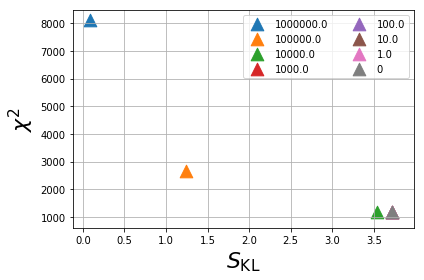

In [10]:
visualize_chi2_skl(bioen_data, theta_series)

## Comparison experimental and weighted ensemble averaged DEER traces

In [11]:
def visualize_cd_data(theta, bioen_data):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    theta_max = np.max(list(bioen_data.keys()))
    
    exp = bioen_data[theta]['exp']['cd']
    exp_err = bioen_data[theta]['exp_err']['cd']
    
    sim_init = bioen_data[theta_max]['sim_init']['cd']
    sim = bioen_data[theta]['sim_wopt']['cd']
    
    ax.plot(exp[:,0], exp[:,1], color='black', linewidth=2.5, label='Exp.',zorder=2)
    ax.fill_between(exp[:,0], exp[:,2]-exp_err, exp[:,2]+exp_err, color='black', alpha=0.2, label='Error', linewidth=1.0, zorder=1)
    ax.plot(exp[:,0], sim_init, color='green', linewidth=3.0, label=r"Uniform weights",zorder=0)
    ax.plot(exp[:,0], sim, color='red', linewidth=3.0, label=r"BioEn".format(theta),zorder=3)
    
    #ax.set_xticks(np.arange(0,4.0,1.0))
    #ax.set_xticklabels(np.arange(0,4.0,1.0), fontsize=fs)
    #ax.set_xlim(0,3.5)
    ax.set_xlabel(r'Wavelength', fontsize=fs+2)

    #ax.set_yticks(np.arange(-0.6,1.4,0.2))
    #ax.set_yticklabels(np.arange(-0.6,1.4,0.2), fontsize=fs)
    #ax.set_ylim(0.35,1.0)
    ax.set_ylabel(r'Molecular elipticity', fontsize=fs)

    ax.legend(loc=1, ncol=2, fontsize=10)
    
    plt.grid()
    
    plt.tight_layout()
    plt.savefig("{}/bioen_cd.png".format(path_output_analysis), dpi=400)
    plt.show()
    return

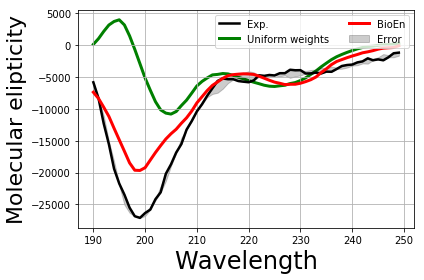

In [12]:
theta = 1000.0
visualize_cd_data(theta, bioen_data)

## Cummulative weight

In [13]:
def visualize_cum_dist(theta, bioen_data):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    nmodels = bioen_data[theta]["nmodels"]
    a = np.vstack((bioen_data[theta]["nmodels_list"], np.array(bioen_data[theta]["wopt"]).reshape(1,-1)))
    
    models = []
    for i, id in enumerate(np.argsort(a[1,:])[::-1]):
        if i == 0: models.append([a[:,id][0], float(a[:,id][1]), float(a[:,id][1])])
        else: models.append([a[:,id][0], float(a[:,id][1]), models[-1][2]+float(a[:,id][1])])

    models = np.array(models)
    ax.scatter(range(1,nmodels+1), models[:,2], s=20, color='green', zorder=2)
    ax.plot(range(1,nmodels+1), models[:,2], color='black', zorder=1)

    ax.set_xticks([0.0, 10.0, 100.0, 1000.0, 10000.0])
    ax.set_xticklabels([r'$10^{0}$', r'$10^{1}$', r'$10^{2}$', r'$10^{3}$', r'$10^{4}$'], fontsize=fs)
    ax.set_xlabel("Fraction of configurations", fontsize=fs)
    ax.semilogx()
    
    ax.set_yticks(np.arange(0,1.2,0.2))
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], fontsize=fs)
    ax.set_ylim(0,1)
    ax.set_ylabel("Cumulative distribution", fontsize=fs)
    
    ax.grid()
    
    plt.savefig('{}/bioen_cum_weights.png'.format(path_output_analysis), dpi=600, bbox_inches='tight')
    return

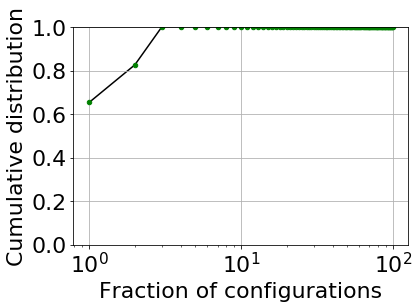

In [14]:
theta = 1000.0
visualize_cum_dist(theta, bioen_data)